In [1]:
import numpy as np, os, sys

import matplotlib.pyplot as plt #patch-wise similarities, droi images
from matplotlib import ticker, cm

import torch.nn as nn
import torch.utils.data 
import torch.nn.functional as F

import torch.optim

In [2]:
def datagen2d_m(mean2, flip, num):    
    a1=np.pi*0.0
    mat1=np.array([ [np.cos(a1), np.sin(a1)  ], [ -np.sin(a1), np.cos(a1)] ] ) 

    a2=np.pi*0.2
    mat2=np.array([ [np.cos(a2), np.sin(a2)  ], [ -np.sin(a2), np.cos(a2)] ] ) 

    z1=np.random.normal(size=(num//2,2))
    z1[:,0]=z1[:,0]*3 
    x1=np.dot(z1,mat1) 
    z2=np.random.normal(size=(num-num//2,2))
    z2[:,0]=z2[:,0]*3 
    x2=np.dot(z2,mat2) + mean2.reshape((1,2))

    y1= (np.random.ranf(size=(num//2)) >= flip ).astype(dtype=np.float32)  #np.ones((num//2))+
    y2=  (np.random.ranf(size=(num-num//2)) <= flip ).astype(dtype=np.float32) #np.zeros((num-num//2,2))

    # random label noise in y1, y2
    x=np.concatenate((x1,x2),axis=0) #existing axis
    y=np.concatenate((y1,y2),axis=0) #existing axis

    #x.shape=(numdata,dims) dims=2 here
    #y.shape=(numdata)

    print('means',np.mean(y1),np.mean(y2),np.mean(y))
    print(x.shape,y.shape)

    # randomly permute
    inds=np.arange(num)
    np.random.shuffle(inds)
    x=x[inds,:]
    y=y[inds]

    return x,y # y is 0 or 1 

In [3]:
def rndsplit_simple(x,y,numtr):

    inds=np.arange(y.size)
    np.random.shuffle(inds)

    xtr=x[inds[0:numtr],:]
    ytr=y[inds[0:numtr]]

    xv=x[inds[numtr:],:]
    yv=y[inds[numtr:]]

    return xtr,ytr,xv,yv

In [4]:
def gendata():
    mean2=np.asarray([1,3])
    flip=0.1
    num=5000
    x,y=datagen2d_m(mean2, flip, num)
    numtr=3000
    xtr,ytr,xvt,yvt=rndsplit_simple(x,y,numtr)
    xv,yv,xt,yt=rndsplit_simple(xvt,yvt,numtr=1000)

    return xtr,ytr,xv,yv,xt,yt

In [5]:
def visualize_data(xv,yv,w,bias):

    possamples=xv[ yv>0, : ]
    negsamples=xv[ yv<=0, : ]

    plt.plot(negsamples[:,0],negsamples[:,1],'bx')
    plt.plot(possamples[:,0],possamples[:,1],'rx')

    #plot wx+b=0 ... wx= -b, x= a w^O + w/\|w\|^2 * -b
    
    def vis1():
    a=np.linspace(-10,10,200)
    worthogonal = np.asarray ( [ -w[1] ,  w[0]   ] ) 
    normedwtimesbias= -bias * w / np.linalg.norm(w)

    points=  a*  worthogonal / np.linalg.norm(w) + normedwtimesbias
    points=points.T
    print(points.shape, w.shape)  

    plt.plot(points[:,0],points[:,1],'c-', linewidth=5)
    
    def vis2():
    delta=0.05
    x = np.arange(-10.0, 12.0, delta)
    y = np.arange(-10.0, 12.0, delta)
    X, Y = np.meshgrid(x, y)  

    U = bias + w[0]*X+ w[1]*Y  
    Z= 1.0/(1.0+np.exp(-U))

    CS = plt.contourf(X, Y, Z, levels=8,cmap=cm.viridis) #coolwarm
    vis2()
    plt.show()


In [9]:
class logreglayer(nn.Module):
    def __init__(self,dims):

        super(logreglayer, self).__init__() #initialize base class

        self.bias = torch.nn.Parameter(data=torch.zeros(1),requires_grad=True)
        #TODO
        # YOUR IMPLEMENTATION HERE # shape must be (dims,1), requires_grad to True , random init of values from a zero mean normal distribution
        self.w = torch.nn.Parameter(data=torch.empty(dims,1), requires_grad=True)     
        
    def forward(self,x):
        #TODO
        # YOUR IMPLEMENTATION HERE
        # Einsum
        output = torch.einsum('ij,jk->ik', x, self.w.type(torch.DoubleTensor)) + self.bias.type(torch.DoubleTensor)
        
        # Pass the output through a sigmoid so that it can be used with BCELoss
        output = (torch.sigmoid_(output))
        
        return output

In [21]:
def train_epoch(lr, model, trainloader, criterion, device, optimizer):
    model.train()
 
    losses = list()
    for batch_idx, data in enumerate(trainloader):

        inputs=data[0].to(device)
        labels=data[1].to(device)
        optimizer.zero_grad()
        
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        
        #apply gradient to your parameters in model ... model.w and model.bias ... remember about data and grad :) 
        #TODO
        # run it at first using the optimizer, and fill up all other todos, 
        # then in a second step replace it by your own version which updates the model parameters
        
#         optimizer.step() ---> outputs around 0.79 accuracy

        # use torch no grad to deactivate the autograd
        with torch.no_grad():
            # update using formula w = w - learning rate * gradient
            model.w -= lr * model.w.grad
            model.bias -= lr * model.bias.grad
            
        losses.append(loss.item())

    return losses

In [27]:
def evaluate(model, dataloader, criterion, device):

    model.eval()

    gtpos=0
    gtneg=0
    tps=0
    tns=0
    fbeta=1

    running_corrects = 0
    with torch.no_grad():
        for ctr, data in enumerate(dataloader):

            print ('epoch at',len(dataloader.dataset), ctr)
            inputs = data[0].to(device)        
            outputs = model(inputs)

            labels = data[1]
            labels = labels.float()
            cpuout= outputs.to('cpu')

#             _, preds = torch.max(cpuout, 1)
            preds = ( cpuout >= 0.5 ).squeeze(1)
            running_corrects += torch.sum(preds == labels.data)

        accuracy = running_corrects.double() / len(dataloader.dataset) # this does not work if one uses a datasampler!!!

    return accuracy.item() 

In [12]:
def train_modelcv(lr, dataloader_cvtrain, dataloader_cvtest ,  model ,  criterion, optimizer, scheduler, num_epochs, device):

    best_measure = 0
    best_epoch =-1

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train(True)
        losses=train_epoch(lr, model,  dataloader_cvtrain,  criterion,  device , optimizer)
        #scheduler.step()

        model.train(False)
        measure = evaluate(model, dataloader_cvtest, criterion, device)
        print(' perfmeasure', measure)

        if measure > best_measure: #higher is better or lower is better?
            bestweights= model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print('current best', measure, ' at epoch ', best_epoch)

    return best_epoch, best_measure, bestweights


In [29]:
def run():
    #some parameters
    #training batch size
    batch_size=8
    #validation batch size
    valbatch_size=32
    # number of epochs for training
    maxnumepochs=12
    # learning rate
    learningrate=0.01

    #define dataset
    xtr,ytr,xv,yv,xt,yt=gendata()

    xtr = torch.from_numpy(xtr).double()
    ytr = torch.from_numpy(ytr).double()
    xv = torch.from_numpy(xv).double()
    yv = torch.from_numpy(yv).double()
    xt = torch.from_numpy(xt).double()
    yt = torch.from_numpy(yt).double()
    
    # Tensordataset
    #TODO
    dtr = torch.utils.data.TensorDataset(xtr,ytr) #TensorDataset from tensors from xtr, ytr - our training features and labels
    
    dv = torch.utils.data.TensorDataset(xv,yv) # TensorDataset from tensors from xv, yv - our validation features and labels
    #define dataloader over dataset
    loadertr=torch.utils.data.DataLoader(dtr,batch_size=batch_size,shuffle=True) # returns an iterator
    loaderval=torch.utils.data.DataLoader(dv,batch_size=valbatch_size,shuffle=False)

    # Model and loss
    #TODO
    model = logreglayer(dims=2) # your logreglayer properly initialized
    #TODO
    criterion = nn.BCELoss() # which loss function suits here, given that our model produces 1-dimensional output  and we want to use it for classification?
    optimizer=torch.optim.SGD(model.parameters(),lr=learningrate, momentum=0.0, weight_decay=0)
    device=torch.device('cpu')

    best_epoch, best_perfmeasure, bestweights = train_modelcv(lr = learningrate, dataloader_cvtrain = loadertr, dataloader_cvtest = loaderval ,  model = model ,  criterion = criterion , optimizer = optimizer, scheduler = None, num_epochs = maxnumepochs , device = device)

    model.load_state_dict(bestweights)

    #TODO
    dte = torch.utils.data.TensorDataset(xt,yt)# TensorDataset from tensors from xte, yte - our test features and labels
    loaderte=torch.utils.data.DataLoader(dte,batch_size=valbatch_size,shuffle=False)

    test_accuracy= evaluate(model = model, dataloader = loaderte, criterion = None, device = device)

    print('validation accuracy',best_perfmeasure, 'test accuracy',test_accuracy)
    
    visualize_data(xt.numpy(),yt.numpy(),model.w.detach(),model.bias.detach())

means 0.8984 0.1016 0.5
(5000, 2) (5000,)
Epoch 0/11
----------


C:\Users\nigel\Anaconda3\envs\humantorch\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch at 1000 0
epoch at 1000 1
epoch at 1000 2
epoch at 1000 3
epoch at 1000 4
epoch at 1000 5
epoch at 1000 6
epoch at 1000 7
epoch at 1000 8
epoch at 1000 9
epoch at 1000 10
epoch at 1000 11
epoch at 1000 12
epoch at 1000 13
epoch at 1000 14
epoch at 1000 15
epoch at 1000 16
epoch at 1000 17
epoch at 1000 18
epoch at 1000 19
epoch at 1000 20
epoch at 1000 21
epoch at 1000 22
epoch at 1000 23
epoch at 1000 24
epoch at 1000 25
epoch at 1000 26
epoch at 1000 27
epoch at 1000 28
epoch at 1000 29
epoch at 1000 30
epoch at 1000 31
 perfmeasure 0.762
current best 0.762  at epoch  0
Epoch 1/11
----------
epoch at 1000 0
epoch at 1000 1
epoch at 1000 2
epoch at 1000 3
epoch at 1000 4
epoch at 1000 5
epoch at 1000 6
epoch at 1000 7
epoch at 1000 8
epoch at 1000 9
epoch at 1000 10
epoch at 1000 11
epoch at 1000 12
epoch at 1000 13
epoch at 1000 14
epoch at 1000 15
epoch at 1000 16
epoch at 1000 17
epoch at 1000 18
epoch at 1000 19
epoch at 1000 20
epoch at 1000 21
epoch at 1000 22
epoch at 100

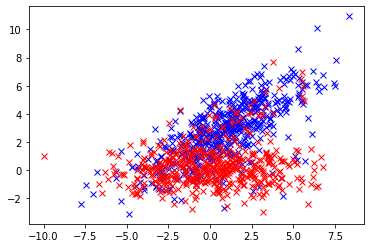

In [30]:
run()